# Sales order data exploration

Use the code in this notebook to explore sales order data.


## Load data into a dataframe


In [ ]:
# With headers 
df = spark.read.format("csv").option("header","true").load("Files/orders/2019.csv")
# df now is a Spark DataFrame containing CSV data from "Files/orders/2019.csv".
display(df)

In [ ]:
# With no headers 
df = spark.read.format("csv").option("header","false").load("Files/orders/2019.csv")
# df now is a Spark DataFrame containing CSV data from "Files/orders/2019.csv".
display(df)

In [ ]:
# Using a schema method and reading only one file 
from pyspark.sql.types import *

orderSchema = StructType([
    StructField("SalesOrderNumber", StringType()),
    StructField("SalesOrderLineNumber", IntegerType()),
    StructField("OrderDate", DateType()),
    StructField("CustomerName", StringType()),
    StructField("Email", StringType()),
    StructField("Item", StringType()),
    StructField("Quantity", IntegerType()),
    StructField("UnitPrice", FloatType()),
    StructField("Tax", FloatType())
    ])

df = spark.read.format("csv").schema(orderSchema).load("Files/orders/2019.csv")
display(df)

In [ ]:
# Using a schema method and reading all files 
from pyspark.sql.types import *

orderSchema = StructType([
    StructField("SalesOrderNumber", StringType()),
    StructField("SalesOrderLineNumber", IntegerType()),
    StructField("OrderDate", DateType()),
    StructField("CustomerName", StringType()),
    StructField("Email", StringType()),
    StructField("Item", StringType()),
    StructField("Quantity", IntegerType()),
    StructField("UnitPrice", FloatType()),
    StructField("Tax", FloatType())
    ])

df = spark.read.format("csv").schema(orderSchema).load("Files/orders/*.csv")
display(df)


## Explore data in a dataframe

### Filter a dataframe

In [ ]:
customers = df['CustomerName', 'Email']
print(customers.count())
print(customers.distinct().count())
display(customers.distinct())

In [ ]:
# With filter
customers = df.select("CustomerName", "Email").where(df['Item']=='Road-250 Red, 52')
print(customers.count())
print(customers.distinct().count())
display(customers.distinct())

### Aggregate and group data in a dataframe


In [ ]:
productSales = df.select("Item", "Quantity").groupBy("Item").sum() # Give sum by group 
display(productSales)

In [ ]:
from pyspark.sql.functions import * 
# Yearly sales 
yearlySales = df.select(year("OrderDate").alias("Year")).groupBy("Year").count().orderBy("Year")
display(yearlySales)

## Use Spark to transform data files


### Use dataframe methods and functions to transform data

In [ ]:
from pyspark.sql.functions import *

## Create Year and Month columns
transformed_df = df.withColumn("Year", year(col("OrderDate"))).withColumn("Month", month(col("OrderDate")))

# Create the new FirstName and LastName fields
transformed_df = transformed_df.withColumn("FirstName", split(col("CustomerName"), " ").getItem(0)).withColumn("LastName", split(col("CustomerName"), " ").getItem(1))

# Filter and reorder columns
transformed_df = transformed_df["SalesOrderNumber", "SalesOrderLineNumber", "OrderDate", "Year", "Month", "FirstName", "LastName", "Email", "Item", "Quantity", "UnitPrice", "Tax"]

# Display the first five orders
display(transformed_df.limit(5))

### Save the transformed data

In [13]:
transformed_df.write.mode("overwrite").parquet('Files/transformed_data/orders')
print ("Transformed data saved!")

StatementMeta(, 2a7c70d2-4533-4f8f-add2-cc3d58fce5eb, 15, Finished, Available, Finished)

Transformed data saved!


In [ ]:
orders_df = spark.read.format("parquet").load("Files/transformed_data/orders")
display(orders_df)

### Save data in partitioned files

In [17]:
orders_df.write.partitionBy("Year","Month").mode("overwrite").parquet("Files/partitioned_data")
print ("Transformed data saved!")

StatementMeta(, 2a7c70d2-4533-4f8f-add2-cc3d58fce5eb, 19, Finished, Available, Finished)

Transformed data saved!


In [ ]:
orders_2021_df = spark.read.format("parquet").load("Files/partitioned_data/Year=2021/Month=*")
display(orders_2021_df)

## Work with tables and SQL

### Create a table

In [ ]:
# Create a new table
df.write.format("delta").saveAsTable("salesorders")

# Get the table description
spark.sql("DESCRIBE EXTENDED salesorders").show(truncate=False)

In [ ]:
# Using embed SQL query 
# df = spark.sql("SELECT * FROM [your_lakehouse].salesorders LIMIT 1000")
df = spark.sql("SELECT * FROM lakehouse_apachespark_ws.salesorders LIMIT 1000")
display(df)

### Run SQL code in a cell


In [ ]:
%%sql
SELECT YEAR(OrderDate) AS OrderYear,
       SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue
FROM salesorders
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;

## Visualize data with Spark

In [ ]:
%%sql
SELECT * FROM salesorders

### Get started with matplotlib


In [ ]:
sqlQuery = "SELECT CAST(YEAR(OrderDate) AS CHAR(4)) AS OrderYear, \
                SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue \
            FROM salesorders \
            GROUP BY CAST(YEAR(OrderDate) AS CHAR(4)) \
            ORDER BY OrderYear"
df_spark = spark.sql(sqlQuery)
df_spark.show()

StatementMeta(, 096a31fc-0294-4741-b8b2-f6a2e9cd6924, 7, Finished, Available, Finished)

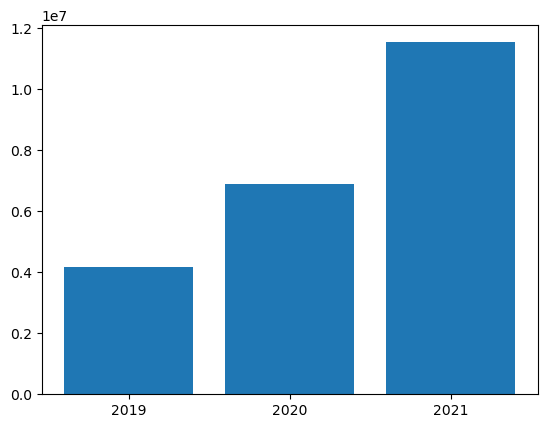

In [5]:
from matplotlib import pyplot as plt

# matplotlib requires a Pandas dataframe, not a Spark one
df_sales = df_spark.toPandas()

# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'])

# Display the plot
plt.show()

StatementMeta(, 096a31fc-0294-4741-b8b2-f6a2e9cd6924, 8, Finished, Available, Finished)

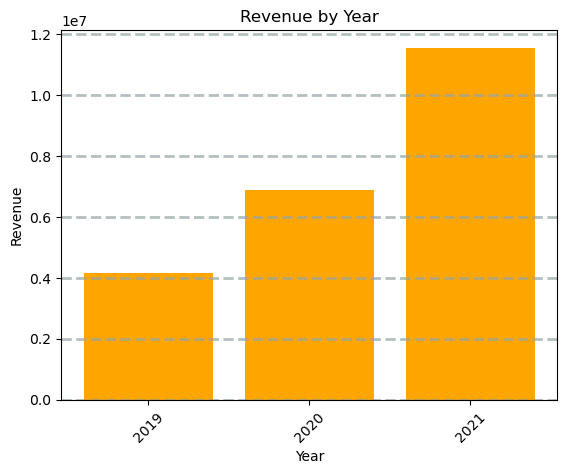

In [6]:
from matplotlib import pyplot as plt

# Clear the plot area
plt.clf()

# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')

# Customize the chart
plt.title('Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)

# Show the figure
plt.show()

StatementMeta(, 096a31fc-0294-4741-b8b2-f6a2e9cd6924, 9, Finished, Available, Finished)

<Figure size 640x480 with 0 Axes>

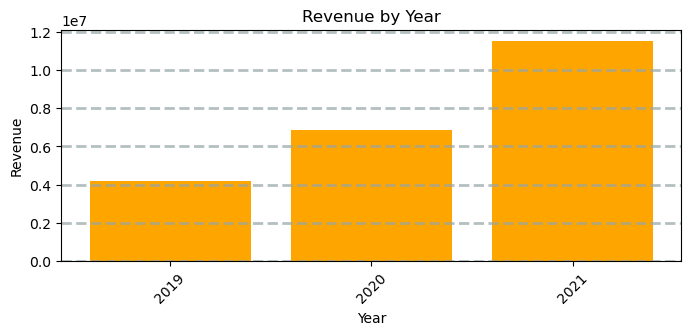

In [7]:
from matplotlib import pyplot as plt

# Clear the plot area
plt.clf()

# Create a Figure
fig = plt.figure(figsize=(8,3))

# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')

# Customize the chart
plt.title('Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)

# Show the figure
plt.show()

StatementMeta(, 096a31fc-0294-4741-b8b2-f6a2e9cd6924, 10, Finished, Available, Finished)

<Figure size 640x480 with 0 Axes>

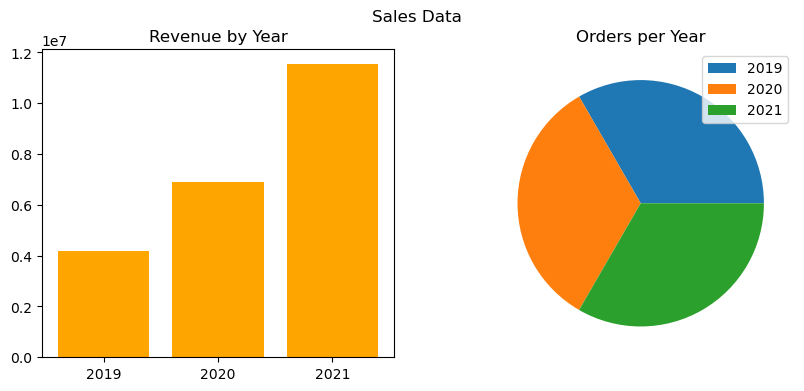

In [8]:
from matplotlib import pyplot as plt

# Clear the plot area
plt.clf()

# Create a figure for 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize = (10,4))

# Create a bar plot of revenue by year on the first axis
ax[0].bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')
ax[0].set_title('Revenue by Year')

# Create a pie chart of yearly order counts on the second axis
yearly_counts = df_sales['OrderYear'].value_counts()
ax[1].pie(yearly_counts)
ax[1].set_title('Orders per Year')
ax[1].legend(yearly_counts.keys().tolist())

# Add a title to the Figure
fig.suptitle('Sales Data')

# Show the figure
plt.show()

### Use the seaborn library

StatementMeta(, 096a31fc-0294-4741-b8b2-f6a2e9cd6924, 11, Finished, Available, Finished)

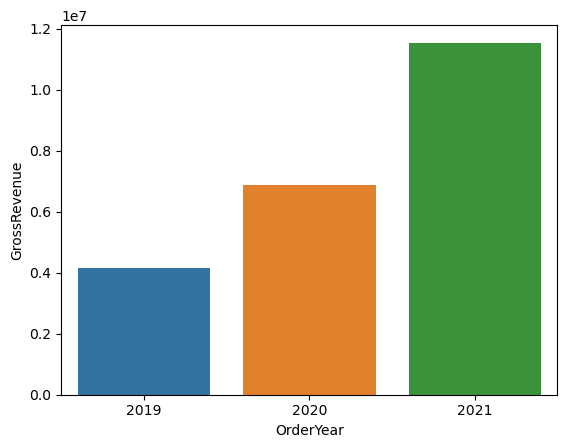

In [9]:
import seaborn as sns

# Clear the plot area
plt.clf()

# Create a bar chart
ax = sns.barplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()

StatementMeta(, 096a31fc-0294-4741-b8b2-f6a2e9cd6924, 12, Finished, Available, Finished)

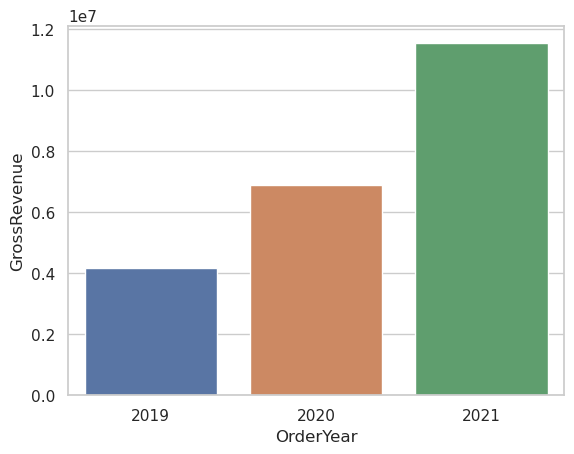

In [10]:
import seaborn as sns

# Clear the plot area
plt.clf()

# Set the visual theme for seaborn
sns.set_theme(style="whitegrid")

# Create a bar chart
ax = sns.barplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()

StatementMeta(, 096a31fc-0294-4741-b8b2-f6a2e9cd6924, 13, Finished, Available, Finished)

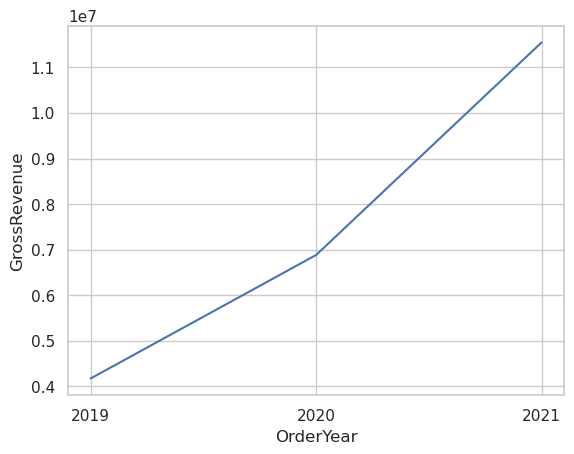

In [11]:
import seaborn as sns

# Clear the plot area
plt.clf()

# Create a line chart
ax = sns.lineplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()